<font color='tomato'><font color="#CC3D3D"><p>
# CDAE: Collaborative Denoising Auto-Encoders

##### Model architecture
<img src='CADE_architecture.png'>

### Import modules

In [1]:
import pandas as pd
import numpy as np
import pickle, random, os
import warnings; warnings.filterwarnings("ignore")
import matplotlib.pylab as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.13.0


### Set random seeds to make your results reproducible

In [2]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")

    np.random.seed(1)
    random.seed(2)
    tf.compat.v1.set_random_seed(3)
#    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET") 
   
reset_seeds()

RANDOM SEEDS RESET


### Step 1: Load and process the data

##### Read data

In [3]:
# load data from MovieLens 100K Dataset
train_users, train_x, test_users, test_x = pd.read_pickle('movie_lens_100k.pkl')

In [4]:
len(train_users), train_x.shape

(943, (943, 1683))

In [5]:
# user-id dimension: 1d -> 2d
train_x_users = np.array(train_users, dtype=np.int32).reshape(len(train_users), 1)
test_x_users = np.array(test_users, dtype=np.int32).reshape(len(test_users), 1)

### Step 2: Define the model architecture

In [6]:
# parameter 설정 
I = train_x.shape[1]    # number of items
U = len(train_users)+1  # number of users
K = 50                  # number of units in hidden layer
q = 0.5                 # drop probability

##### Stack layers from input to output

In [7]:
x_item = keras.Input((I,), name='x_item')
h_item = keras.layers.Dropout(q)(x_item)  # Denoising
h_item = keras.layers.Dense(K, kernel_regularizer=keras.regularizers.L2(), bias_regularizer=keras.regularizers.L2())(h_item)


x_user = keras.Input((1,), dtype='int32', name='x_user')  # dtype should be int to connect to Embedding layer
h_user = keras.layers.Embedding(input_dim=U, output_dim=K, input_length=1, embeddings_regularizer=keras.regularizers.L2())(x_user)
h_user = keras.layers.Flatten()(h_user)

h = keras.layers.Add()([h_item, h_user])
h = keras.layers.Activation('relu')(h)
y = keras.layers.Dense(I, activation='sigmoid')(h)

model = keras.Model(inputs=[x_item, x_user], outputs=y)

##### Summarize & visualize the model

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x_item (InputLayer)         [(None, 1683)]               0         []                            
                                                                                                  
 x_user (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 dropout (Dropout)           (None, 1683)                 0         ['x_item[0][0]']              
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                47200     ['x_user[0][0]']              
                                                                                              

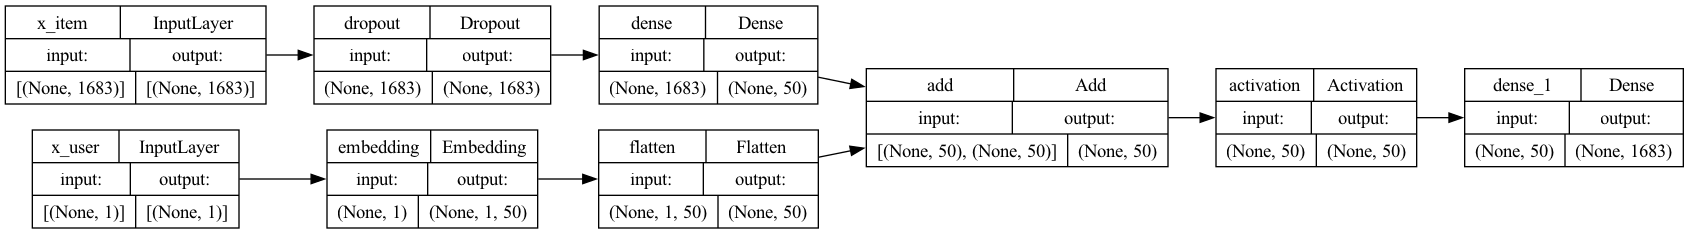

In [9]:
# 연결 그래프 시각화
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### Step 3: Choose the optimizer and the cost function

In [10]:
# loss, optimizer, metrics 설정
model.compile(loss='mean_absolute_error', optimizer='adam')

### Step 4: Train the model

##### Set learning conditions & fit the model 

In [11]:
hist = model.fit(x=[train_x, train_x_users], 
                 y=train_x,
                 validation_data=[[test_x, test_x_users], test_x],
                 batch_size=128, 
                 epochs=1000, 
                 verbose=1)

Epoch 1/1000
8/8 [==============================] - 0s 13ms/step - loss: 1.6472 - val_loss: 1.3608
Epoch 2/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.1938 - val_loss: 1.0098
Epoch 3/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.8607 - val_loss: 0.7842
Epoch 4/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.5995 - val_loss: 0.6411
Epoch 5/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.4285 - val_loss: 0.5427
Epoch 6/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.3248 - val_loss: 0.4716
Epoch 7/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.2619 - val_loss: 0.4221
Epoch 8/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.2245 - val_loss: 0.3883
Epoch 9/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.2019 - val_loss: 0.3633
Epoch 10/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.1872 - val_loss: 0.3432
Epoch 11/1000
8/8 

##### Visualize training history 

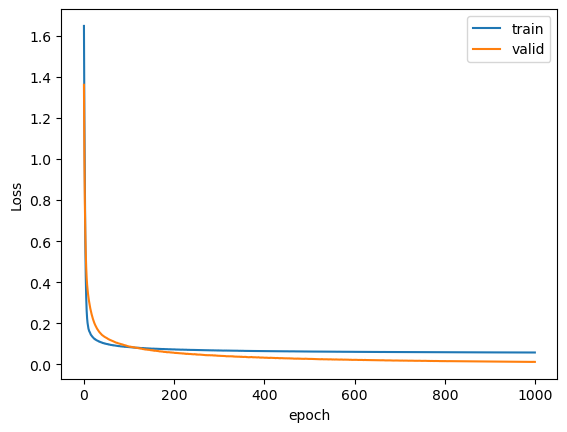

In [12]:
# Plot RMSE

plt.plot(hist.history['loss'], label="train")
plt.plot(hist.history['val_loss'], label="valid")
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Step 5: Make recommendations

In [13]:
top_k = 10

# predict
pred = model.predict(x=[train_x, np.array(train_users, dtype=np.int32).reshape(len(train_users), 1)])
# remove watched items from predictions
pred = pred * (train_x == 0) 
# rank
pred = np.argsort(pred)
# top-k recommendations
pd.DataFrame(pred[:,-top_k:])

30/30 [==============================] - 0s 589us/step


,0,1,2,3,4,5,6,7,8,9
0,1232,574,1396,1361,745,1674,759,1537,288,294
1,759,1537,172,174,98,56,7,121,181,50
2,172,174,98,56,7,121,1,50,100,294
3,98,56,174,7,121,1,181,100,294,50
4,759,1537,127,288,258,294,7,1,98,56
...,...,...,...,...,...,...,...,...,...,...
938,98,56,174,121,1,294,181,258,100,50
939,1396,1361,745,1674,759,1537,127,288,1,121
940,172,7,98,56,174,121,181,258,100,50
941,127,288,7,294,98,56,1,121,181,100


In [14]:
def hit_rate(pred, true):
    cnt = 0
    for i in range(pred.shape[0]): # 각 사용자별로
        t = np.where(true[i] == 1) # Positive-아이템ID 리스트 추출
        ary = np.intersect1d(pred[i], t) # 교집합(추천리스트, Positive리스트)
        if ary.size > 0:
            cnt += 1
    return cnt / pred.shape[0]

In [15]:
# Evaluate CDAE using Hit-rate: Top-1 to Top-10
for n in range(1, 11): 
    print(f"Success Rate at {n:2d}: {hit_rate(pred[:, -n:], test_x):.6f}")

Success Rate at  1: 0.272534
Success Rate at  2: 0.388123
Success Rate at  3: 0.449629
Success Rate at  4: 0.490986
Success Rate at  5: 0.510074
Success Rate at  6: 0.530223
Success Rate at  7: 0.541888
Success Rate at  8: 0.555673
Success Rate at  9: 0.563097
Success Rate at 10: 0.571580


<font color="#CC3D3D"><p>
# End